<a href="https://colab.research.google.com/github/UjfalusiAbel/Tananyag/blob/main/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd

import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import requests
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

----------------------------------------------------
----------------------------------------------------


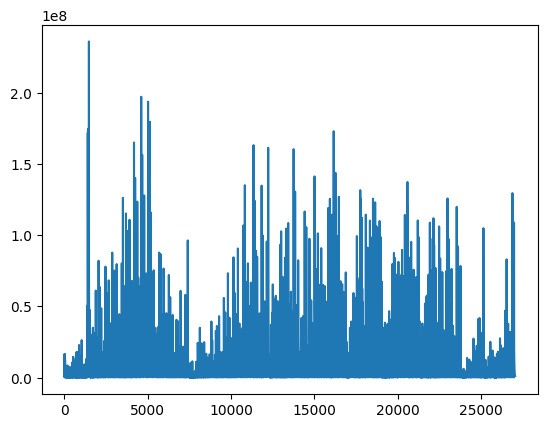

In [10]:
# Read the downloaded data into a DataFrame
df = pd.read_csv("cinemaTicket_Ref.csv", header=0)
#print(df.head())  # Display the first few rows of the DataFrame
#print(df.describe())
df.dropna(subset=["total_sales"], inplace=True)
#result = adfuller(df["total_sales"].values)
print('----------------------------------------------------')
#print('p-value: %f' % result[1])
#print("Should be under 0.05 if the process is stationary")
print('----------------------------------------------------')

reindexed_df = df.copy()
reindexed_df.month = reindexed_df.month.astype('datetime64[ns]')
reindexed_df = reindexed_df.set_index("date")
df["total_sales"].plot();

# New Section

# New Section

In [11]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

window_size = 10


rolled_data = rolling_window(df["total_sales"].values, window_size+1)

rolled_train_data, rolled_test_data = train_test_split(rolled_data, test_size=0.1, shuffle=False)

rolled_train_y = rolled_train_data[:,window_size]
rolled_train_x = rolled_train_data[:,:window_size]

rolled_test_y = rolled_test_data[:,window_size]
rolled_test_x = rolled_test_data[:,:window_size]
print(rolled_test_x.shape)
print(rolled_test_y.shape)

(2704, 10)
(2704,)


In [12]:
rolled_train_x.shape

(24327, 10)

In [14]:

hidden_1_size = 17
hidden_2_size = 9

training_epochs = 60
learning_rate = 0.001
l1_lambda = 0.00015

# Model
#######

inputs = Input(shape=(window_size,))

# Hidden layers

hidden_output_1 = Dense(hidden_1_size, activation='relu', kernel_regularizer=l1(l1_lambda), bias_regularizer=l1(l1_lambda))(inputs)
hidden_output_2 = Dense(hidden_2_size, activation='relu', kernel_regularizer=l1(l1_lambda), bias_regularizer=l1(l1_lambda))(hidden_output_1)

# Prediction layer
predictions = Dense(1, activation='linear')(hidden_output_2)


# Full model
model = Model(inputs=inputs, outputs=predictions)

# Optimizer
####################

optimizer = Adam(lr=learning_rate)


# Compilation and fitting
#########################

model.compile(optimizer=optimizer, loss='mean_squared_error')
with tf.device('/gpu:0'):
  history = model.fit(x=rolled_train_x,
                    y=rolled_train_y,
                    validation_data=(rolled_test_x,rolled_test_y),
                    epochs=training_epochs,
                    batch_size=None)

Epoch 1/60
761/761 [==============================] - 10s 5ms/step - loss: 117296076947456.0000 - val_loss: 31444116176896.0000
Epoch 2/60
761/761 [==============================] - 3s 4ms/step - loss: 86847669665792.0000 - val_loss: 32145036804096.0000
Epoch 3/60
761/761 [==============================] - 3s 4ms/step - loss: 86566768738304.0000 - val_loss: 31841794916352.0000
Epoch 4/60
761/761 [==============================] - 3s 4ms/step - loss: 86393795641344.0000 - val_loss: 32105719398400.0000
Epoch 5/60
761/761 [==============================] - 4s 5ms/step - loss: 86282118103040.0000 - val_loss: 32188902932480.0000
Epoch 6/60
761/761 [==============================] - 3s 4ms/step - loss: 86204993241088.0000 - val_loss: 31712614547456.0000
Epoch 7/60
761/761 [==============================] - 3s 4ms/step - loss: 86126811414528.0000 - val_loss: 31868021899264.0000
Epoch 8/60
761/761 [==============================] - 3s 4ms/step - loss: 86155374624768.0000 - val_loss: 3194224430

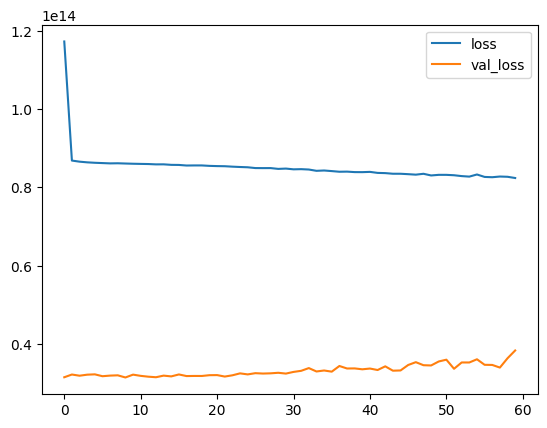

In [15]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [22]:
print("The minimum for the val_loss is at epoch:",np.array(history.history["val_loss"]).argmin())

The minimum for the val_loss is at epoch: 38


In [17]:
# Splitting the data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.1, shuffle=False)

# Making predictions on the training and test sets
train_predictions = model.predict(rolled_train_x)
test_predictions = model.predict(rolled_test_x)

# Creating Pandas Series for the predictions
out_layer_result_train = pd.Series(train_predictions.flatten())
out_layer_result_test = pd.Series(test_predictions.flatten())

# Adjusting the indices for visualization
idx = train_data.index[10:]
idx = list(idx)
idx.append(train_data.index[-1] + 1)
out_layer_result_train.index = pd.Index(idx)
out_layer_result_test.index = test_data.index[1:]


85/85 [==============================] - 0s 2ms/step


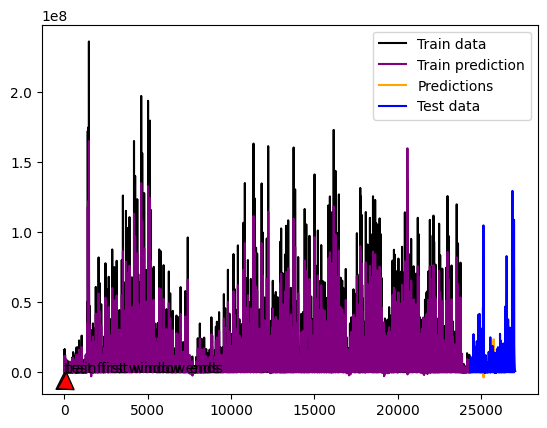

In [18]:
out_layer_result_train = pd.Series(train_predictions.flatten())
out_layer_result_test = pd.Series(test_predictions.flatten())

# Adjusting the indices for visualization
idx = train_data.index[10:]
idx = list(idx)
idx.append(train_data.index[-1] + 1)
out_layer_result_train.index = pd.Index(idx)
out_layer_result_test.index = test_data.index[1:]

# Plotting the results
plt.close()

# Explicitly create a new axes instance with a unique label
fig, ax = plt.subplots()

ax.plot(train_data["total_sales"], label="Train data", color="black")
ax.plot(out_layer_result_train, label="Train prediction", color="purple")
ax.plot(out_layer_result_test, label="Predictions", color="orange")
ax.plot(test_data["total_sales"], label="Test data", color="blue")

# Adding annotations to the plot
ax.annotate('train first window ends', xy=(10, 140), xytext=(10, 210),
            arrowprops=dict(facecolor='red', shrink=0.05),)
ax.annotate('test first window ends', xy=(130, 340), xytext=(122, 270),
            arrowprops=dict(facecolor='red', shrink=0.05),)

# Displaying legends and the plot
ax.legend()
plt.show()